# XHEC: Session 6-2  

Explore topic extraction and sentiment analysis existing libraries 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!pwd

/content


In [ ]:
import os
os.chdir("drive/MyDrive/Capgemini")

In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 24.2MB 129kB/s 
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/utils/logging.py", line 225, in format
    msg = logging.StreamHandler.format(self, record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/utils/logging.py", line 151, in format
    formatted = super(IndentingFormatter, self).format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_install.py", line 181, in __str__
    s += ' in %s' % display_path(self.satisfied_by.location)
 

## Import libraries 

In [ ]:
!git clone https://github.com/rwalk/gsdmm
!pip install transformers==2.4.1
!pip install flair

fatal: destination path 'gsdmm' already exists and is not an empty directory.
     |████████████████████████████████| 481kB 3.9MB/s 
     |████████████████████████████████| 133kB 6.3MB/s 
     |████████████████████████████████| 4.7MB 7.9MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 7.3MB 34.2MB/s 
ERROR: flair 0.7 has requirement transformers<=3.5.1,>=3.5.0, but you'll have transformers 2.4.1 which is incompatible.
ERROR: botocore 1.20.27 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
  Found existing installation: tokenizers 0.9.3
    Uninstalling tokenizers-0.9.3:
      Successfully uninstalled tokenizers-0.9.3
  Found existing installation: transformers 3.5.1
    Uninstalling transformers-3.5.1:
      Successfully uninstalled transformers-3.5.1
  Using cached https://files.pythonhosted.org/packages/3a/83/e74092e7f24a08d751aa59b37a9fc572b2e4af3918cb66f7766c3affb1b4/transformers-3.5.1-p

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
import gensim
import gensim.corpora as corpor
import pyLDAvis
import pyLDAvis.gensim
from gsdmm.gsdmm import MovieGroupProcess
from gensim.models.coherencemodel import CoherenceModel
import operator
from tqdm import tqdm_notebook as tqdm

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [ ]:
import flair
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
nltk.download('vader_lexicon')
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


2021-03-15 09:28:48,818 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_3.1.pt not found in cache, downloading to /tmp/tmpd8w62ud9


100%|██████████| 266147697/266147697 [00:06<00:00, 38098483.53B/s]

2021-03-15 09:28:55,956 copying /tmp/tmpd8w62ud9 to cache at /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


2021-03-15 09:28:56,506 removing temp file /tmp/tmpd8w62ud9
2021-03-15 09:28:56,963 loading file /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
#os.chdir(os.path.join(os.getcwd(), "Capgemini/sentiment_analysis"))
#if os.path.exists(os.path.join("nlp_consulting_project")):
 #   print("Directory nlp_consulting_project exists")
  #  os.chdir(os.path.join("nlp_consulting_project"))
   # !git pull

#else:
!git clone https://github.com/hehlinge42/nlp_consulting_project.git
os.chdir("nlp_consulting_project")

fatal: destination path 'nlp_consulting_project' already exists and is not an empty directory.


In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1ybXeykwPZpH6cQotk9oa_AVlmpjjt82k/Capgemini/sentiment_analysis/nlp_consulting_project


## Load data 

In [ ]:
bokan_reviews = pd.read_json(os.path.join('cleaner', 'cleaned_data', 'bokan_37', 'tokenized_corpus.json'), lines=True)
bokan_reviews = bokan_reviews.transpose()
bokan_reviews.rename({0: "clean_content"}, axis=1, inplace=True)

In [ ]:
bokan_reviews.head()

,clean_content
1,"[really, glad, open, new, menu, amazing, reall..."
2,"[arrive, 45, minute, late, due, london, traffi..."
3,"[lovely, ambiance, nice, most, thoughtful, sta..."
4,"[friend, last, year, nice, joyful, staff, help..."
5,"[tonight, go, bokan, group, friend, tell, fant..."


## Topic extraction 

### LDA with gensim 

In [ ]:
#Dictionary
tokens = bokan_reviews.clean_content
dictionary = gensim.corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=0.05, no_above=0.9)
corpus = [dictionary.doc2bow(tok) for tok in tokens]

In [ ]:
ldaModel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=42,
                                           alpha=0.1,
                                           eta=0.1,
                                           per_word_topics=True)

In [ ]:
for i,topic in ldaModel.show_topics(formatted=True, num_topics=10, num_words=20):
    print(str(i)+": "+ topic+"\n")

0: 0.021*"view" + 0.020*"very" + 0.010*"drink" + 0.009*"staff" + 0.008*"u" + 0.008*"place" + 0.008*"one" + 0.008*"london" + 0.007*"bar" + 0.007*"go" + 0.007*"bokan" + 0.006*"good" + 0.006*"would" + 0.006*"great" + 0.006*"not" + 0.006*"recommend" + 0.006*"make" + 0.005*"price" + 0.005*"service" + 0.005*"back"

1: 0.015*"bar" + 0.013*"not" + 0.013*"staff" + 0.012*"very" + 0.010*"view" + 0.010*"service" + 0.009*"order" + 0.009*"drink" + 0.008*"table" + 0.007*"time" + 0.007*"even" + 0.007*"go" + 0.006*"come" + 0.006*"take" + 0.006*"try" + 0.005*"would" + 0.005*"great" + 0.005*"good" + 0.005*"wait" + 0.005*"one"

2: 0.016*"view" + 0.014*"not" + 0.013*"service" + 0.011*"go" + 0.011*"very" + 0.010*"u" + 0.010*"bar" + 0.010*"good" + 0.009*"great" + 0.008*"london" + 0.008*"place" + 0.008*"bokan" + 0.008*"drink" + 0.007*"would" + 0.007*"night" + 0.007*"staff" + 0.007*"dinner" + 0.006*"time" + 0.006*"nice" + 0.006*"well"

3: 0.022*"drink" + 0.020*"view" + 0.013*"bar" + 0.011*"service" + 0.010*"st

In [ ]:
cm = CoherenceModel(model=ldaModel, corpus=corpus, texts=tokens ,coherence="c_v")
cm.get_coherence()

0.33702799671730166

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldaModel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.000387  0.011382       1        1  14.830917
9      0.019860  0.018739       2        1  14.234360
5      0.000851  0.018672       3        1  13.076146
7      0.024177  0.021039       4        1  11.873885
2      0.003133  0.005085       5        1  11.368128
4     -0.010886 -0.045363       6        1   9.607186
3      0.020651 -0.042689       7        1   9.441144
1      0.030086  0.006830       8        1   6.753489
0     -0.012341 -0.004016       9        1   4.600184
6     -0.075145  0.010321      10        1   4.214560, topic_info=          Term        Freq       Total Category  logprob  loglift
42        view  442.000000  442.000000  Default  30.0000  30.0000
41        very  298.000000  298.000000  Default  29.0000  29.0000
28      london  175.000000  175.000000  Default  28.0000  28.0000
75       great  225.000000  225.000000  Default  27.0000  27.0000
112      drink  251.000000  251.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
35   recommend    4.559254  100.694266  Topic10  -5.4830   0.0717
57          go    5.349778  238.422934  Topic10  -5.3231  -0.6304
133      visit    4.593464  116.876212  Topic10  -5.4755  -0.0699
6         menu    4.513175  131.593442  Topic10  -5.4931  -0.2061
295        one    4.228007  134.643694  Topic10  -5.5584  -0.2943

[783 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
961       1  0.136791       &
961       2  0.034198       &
961       3  0.170988       &
961       4  0.102593       &
961       5  0.068395       &
...     ...       ...     ...
54        8  0.063055   would
54        9  0.044138   would
54       10  0.031527   would
2130     10  0.636621    xxxx
2470      6  0.578007  yummmm

[1939 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 6, 8, 3, 5, 4, 2, 1, 7])

In [ ]:
#with open(f'model/lda_model.pkl', 'wb') as f:
#    pickle.dump(ldaModel, f)
#    f.close()

### GSDMM 

In [ ]:
bokan_reviews['nb_token'] = list(map(len, bokan_reviews['clean_content']))
docs = bokan_reviews.clean_content.to_list()
vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)

In [ ]:
nb_topic = 10
alpha = 0.1
beta = 0.1

mgpModel = MovieGroupProcess(K=nb_topic, alpha=alpha, beta=beta, n_iters=20)
mgpModelFit = mgpModel.fit(tokens, n_terms)

# Save model
#with open(f'model/gsdmm_model.pkl', 'wb') as f:
#    pickle.dump(mgpModel, f)
#    f.close()

In stage 0: transferred 451 clusters with 10 clusters populated
In stage 1: transferred 211 clusters with 9 clusters populated
In stage 2: transferred 102 clusters with 8 clusters populated
In stage 3: transferred 59 clusters with 5 clusters populated
In stage 4: transferred 35 clusters with 5 clusters populated
In stage 5: transferred 26 clusters with 3 clusters populated
In stage 6: transferred 20 clusters with 4 clusters populated
In stage 7: transferred 15 clusters with 4 clusters populated
In stage 8: transferred 13 clusters with 4 clusters populated
In stage 9: transferred 14 clusters with 4 clusters populated
In stage 10: transferred 21 clusters with 4 clusters populated
In stage 11: transferred 14 clusters with 4 clusters populated
In stage 12: transferred 25 clusters with 4 clusters populated
In stage 13: transferred 21 clusters with 4 clusters populated
In stage 14: transferred 18 clusters with 5 clusters populated
In stage 15: transferred 23 clusters with 5 clusters populate

In [ ]:
def topWordsPerTopic(clusterDistrib, topIndex, nbWord):
    for index in topIndex:
        clusterWord = clusterDistrib[index]
        sortedCluster = sorted(clusterWord.items(), key=operator.itemgetter(1), reverse=True)
        clusterTopWords = sortedCluster[:nbWord]
        print(f"Cluster {index} : {clusterTopWords}")
        print('*'*20)

In [ ]:
docCount = np.array(mgpModel.cluster_doc_count)
print('Number of documents per topic :', docCount)
print('*'*20)
# Topics sorted by the number of document they are allocated to
topIndex = docCount.argsort()[::-1]
print('Most important clusters (by number of docs inside):', topIndex)
print('*'*20)
# Show the top 30 words in term frequency for each cluster 
topWordsPerTopic(mgpModel.cluster_word_distribution, topIndex, 30)

Number of documents per topic : [  0   0   0   1   0  11   1   0 332 182]
********************
Most important clusters (by number of docs inside): [8 9 5 6 3 7 4 2 1 0]
********************
Cluster 8 : [('view', 317), ('very', 195), ('great', 169), ('service', 146), ('london', 137), ('staff', 136), ('go', 127), ('bar', 118), ('bokan', 110), ('good', 103), ('drink', 92), ('amazing', 86), ('not', 84), ('make', 84), ('friendly', 77), ('place', 76), ('visit', 73), ('amaze', 73), ('would', 73), ('u', 73), ('recommend', 71), ('definitely', 71), ('floor', 70), ('nice', 68), ('dinner', 68), ('menu', 67), ('really', 65), ('table', 64), ('night', 63), ('cocktail', 61)]
********************
Cluster 9 : [('not', 259), ('bar', 189), ('drink', 185), ('view', 171), ('service', 168), ('table', 153), ('u', 143), ('very', 139), ('go', 134), ('staff', 123), ('time', 120), ('order', 118), ('get', 115), ('take', 113), ('good', 105), ('would', 104), ('one', 101), ('come', 100), ('say', 95), ('ask', 95), ('n

### pyLDAvis with gsdmm

In [ ]:
#Topic-term matrix shape (n_topic, n_term)
def createTopicTermMatrix(vocab, mgp):
    zero = np.zeros((len(mgp.cluster_word_distribution), len(vocab)))
    df = pd.DataFrame(data=zero, columns=list(vocab))
    for i, cluster_word_distrib in tqdm(enumerate(mgp.cluster_word_distribution)):
        for key, val in cluster_word_distrib.items():
            df.loc[i, key] = val
    return df

In [ ]:
TopicTermMatrix = createTopicTermMatrix(vocab, mgpModel)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


0it [00:00, ?it/s]

In [ ]:
#Matrix of document-topic probabilities shape (n_doc, n_topics)
def createDocumentTopicProbaMatrix(mgp, doc_list):
    score_per_doc = []
    for doc in tqdm(doc_list):
        score_per_doc.append(mgp.score(doc))
    df = pd.DataFrame(data=score_per_doc, columns=[i for i in range(nb_topic)])
    return df

In [ ]:
probaDocumentTopicMatrix = createDocumentTopicProbaMatrix(mgpModel, docs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/527 [00:00<?, ?it/s]

In [ ]:
def deleteNonPorcessedDocument(probaDocumentTopicMatrix, document):
    check = probaDocumentTopicMatrix.sum(axis=1)
    toDelete = check[check==0]
    idxToDelete = toDelete.index 
    probaDocumentTopicMatrix = probaDocumentTopicMatrix.drop(idxToDelete)
    
    idx = list(map(lambda x: document.index[x], idxToDelete))
    document = document.drop(idx)
    return probaDocumentTopicMatrix, document

In [ ]:
probaDocumentTopicMatrixClean, documentClean = deleteNonPorcessedDocument(probaDocumentTopicMatrix, bokan_reviews)

In [ ]:
#doc length shape (n_doc)
docLength = documentClean.nb_token
print(len(documentClean))

488


In [ ]:
#doc length shape (n_term)
vocabList = list(vocab) 

In [ ]:
#Term frequency shape (n_term)
def term_frequency(vocab_list, doc_list):
    res = []
    for word in tqdm(vocab_list):
        word_per_doc = sum(list(map(lambda x: x.count(word), doc_list)))
        res.append(word_per_doc)
    return res

In [ ]:
termFrequencyList = term_frequency(vocabList, docs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/3361 [00:00<?, ?it/s]

In [ ]:
# %%time
# vis = pyLDAvis.prepare(TopicTermMatrix, probaDocumentTopicMatrixClean, docLength, vocabList, termFrequencyList, sort_topics=False)
# pyLDAvis.display(vis)

## Sentiment analysis 

In [ ]:
bokan_full_reviews = pd.read_json(os.path.join('scraper', 'scraper_rooftops', 'scraped_data', 'reviews', 'reviews_id_6.json'), lines=True)
bokan_full_reviews.set_index(['review_id'], inplace=True)
bokan_full_reviews.head()

,restaurant_id,username,date_of_visit,rating,title,comment,date_of_review
review_id,,,,,,,
1,-6,Companion26528469532,October 2020,5,Excellent hospitality,Excellent! I arrived 10 minutes before the bre...,13 October 2020
2,-6,F3847EHjoshd,October 2020,5,Went for my partners birthday,Went for my partners birthday and everything w...,31 October 2020
3,-6,jessicaloyd,October 2020,3,Nice place,Lovely view. The food was good. Tapas was tast...,11 October 2020
4,-6,pnhmrk,October 2020,2,Oh dear,This restaurant didn’t actually do anything wr...,23 October 2020
5,-6,thaisaA6432QL,October 2020,4,Salah ( Host ) has a very bad attitude,On my second visit I was greeted by Salah ( no...,19 October 2020


In [ ]:
bokan_full_reviews[bokan_full_reviews['rating'] == 1].head()

,restaurant_id,username,date_of_visit,rating,title,comment,date_of_review
review_id,,,,,,,
9,-6,JaneSmalls,December 2020,1,Such a disappointment and not worth it,Don’t even know from where to start because ev...,10 December 2020
13,-6,David S,September 2020,1,Overpriced - surly staff,This is the usual for such a bar/restaurant un...,23 September 2020
17,-6,D8917KThannahw,October 2020,1,Not great and quite overpriced,Views may be good in the right seat but most s...,1 October 2020
18,-6,DayDrinker12345,October 2020,1,"Wasn’t allowed to move to outside seating, but...",Was sat inside despite booking a month in adva...,1 October 2020
19,-6,nataliafK2248WB,August 2020,1,Do not come here!!!,Came to this restaurant with a few of my frien...,2 October 2020


In [ ]:
import re

all_sentences = bokan_full_reviews.comment.tolist()
list_reviews = []
list_sentences = []
end_of_sentences = ['. ', '? ', '! ', '...']
for review in all_sentences:
    for d in end_of_sentences:
        review = review.replace(d, 'end_of_sentence')
    list_reviews.append(review)

for review in list_reviews:
    list_sentences.extend(review.split('end_of_sentence'))

list_sentences = list(filter(lambda item: item, list_sentences))

In [ ]:
all_sentences

['Excellent! I arrived 10 minutes before the breakfast service close and they had absolutely no problem to serving me breakfast.. with an amazing view of London city.. The service, hospitality, location, the place.. I will come back!',
 'Went for my partners birthday and everything was excellent! Y. Terrel looked after us and was extremely attentive. Will definitely return. Amazing view of the city as well. ',
 'Lovely view. The food was good. Tapas was tasty and the cocktails very nice. Service was a bit slow. ',
 'This restaurant didn’t actually do anything wrong; the service was good, friendly and helpful; but the food doesn’t get anywhere near a quality to match what the restaurant is charging :( The whole place - both the hotel (reviewed elsewhere) and this restaurant - seem stuck in a time warp. The design would have been very suited to 15 years ago. However nothing has changed. I don’t think that people want to eat from a very limited (they only offer a choice of three puddings)

In [ ]:
list_sentences

['Excellent',
 'I arrived 10 minutes before the breakfast service close and they had absolutely no problem to serving me breakfast.',
 'with an amazing view of London city.',
 'The service, hospitality, location, the place.',
 'I will come back!',
 'Went for my partners birthday and everything was excellent',
 'Y',
 'Terrel looked after us and was extremely attentive',
 'Will definitely return',
 'Amazing view of the city as well',
 'Lovely view',
 'The food was good',
 'Tapas was tasty and the cocktails very nice',
 'Service was a bit slow',
 'This restaurant didn’t actually do anything wrong; the service was good, friendly and helpful; but the food doesn’t get anywhere near a quality to match what the restaurant is charging :( The whole place - both the hotel (reviewed elsewhere) and this restaurant - seem stuck in a time warp',
 'The design would have been very suited to 15 years ago',
 'However nothing has changed',
 'I don’t think that people want to eat from a very limited (they 

In [ ]:
avg_scores_list = []
sid = SentimentIntensityAnalyzer()

print(f"There are {len(list_sentences)} sentences")

for i, sentence in enumerate(all_sentences):

    s = flair.data.Sentence(sentence)
    tokens = [token.text for token in s.tokens]
    ss = [flair.data.Sentence(s) for s in tokens]
    [flair_sentiment.predict(s) for s in ss]
    sentiments = [s.labels[0].score * (-1,1)[str(s.labels[0]).split()[0].startswith("POS")] for s in ss]
    avg_scores_list.append(np.mean(sentiments))
    print(f"{i}, {np.mean(sentiments)}, {sentence}")

    if i >= 100:
        break

avg_scores_list[0:2]

There are 12637 sentences
0, 0.7949385378095839, Excellent! I arrived 10 minutes before the breakfast service close and they had absolutely no problem to serving me breakfast.. with an amazing view of London city.. The service, hospitality, location, the place.. I will come back!
1, 0.6955685988068581, Went for my partners birthday and everything was excellent! Y. Terrel looked after us and was extremely attentive. Will definitely return. Amazing view of the city as well. 
2, 0.6740401879600857, Lovely view. The food was good. Tapas was tasty and the cocktails very nice. Service was a bit slow. 
3, 0.5576200128065473, This restaurant didn’t actually do anything wrong; the service was good, friendly and helpful; but the food doesn’t get anywhere near a quality to match what the restaurant is charging :( The whole place - both the hotel (reviewed elsewhere) and this restaurant - seem stuck in a time warp. The design would have been very suited to 15 years ago. However nothing has changed

[0.7949385378095839, 0.6955685988068581]

In [ ]:
print(np.argsort(avg_scores_list))

[ 39   4  41  31  55  84  18  57  63  28  83  48   3   8  30  40  44  42
  17  19  37  82  56  66  29  54  15  53  45  24  79  50  34  70  65  26
  59  38  61  64  43  46  20  88  86  74  81   9  52  91  22  67  77  16
  87  69  97   2  51  73  35  47  21  93   1  96  25  12  80  75  89  85
  68  95   5  36  13  71  10  72  60  78  11  76  32  14  90  62   0  49
  27  58  33  23  99  98 100   7   6  92  94]


In [ ]:
i_comment = 93

sentence = bokan_full_reviews.comment[i_comment]
sentence = list_sentences[i_comment]
sentence = all_sentences[15]

sentence

'We only stopped in for a few sundowners so can’t comment on the food. Gorgeous bar with great views, delicious signature cocktails and great service. Good social distancing plan, however the man that greats you at the lift maybe takes it a step too far. Made us scan in four times which made no sense. Maybe a lack of understanding how the scanning app works.'

### VADER Sentiment analysis 

In [ ]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(sentence)

{'compound': 0.9371, 'neg': 0.081, 'neu': 0.682, 'pos': 0.237}

In [ ]:
sns.set(rc={'figure.figsize':(30,1)})

def visualise_sentiments(data):
    sns.heatmap(pd.DataFrame(data).set_index("Sentence").T,center=0, annot=True, cmap = "PiYG")

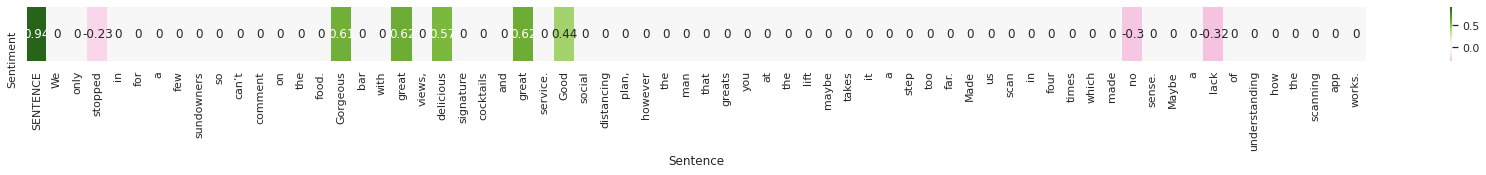

In [ ]:
visualise_sentiments({
    "Sentence":["SENTENCE"] + sentence.split(),
    "Sentiment":[sid.polarity_scores(sentence)["compound"]] + [sid.polarity_scores(word)["compound"] for word in sentence.split()]
})

### Flair Sentiment analysis 

In [ ]:
s = flair.data.Sentence(sentence)
flair_sentiment.predict(s)
total_sentiment = s.labels
total_sentiment

[POSITIVE (0.9962)]

In [ ]:
str(total_sentiment[0]).split(' (')[0]

'POSITIVE'

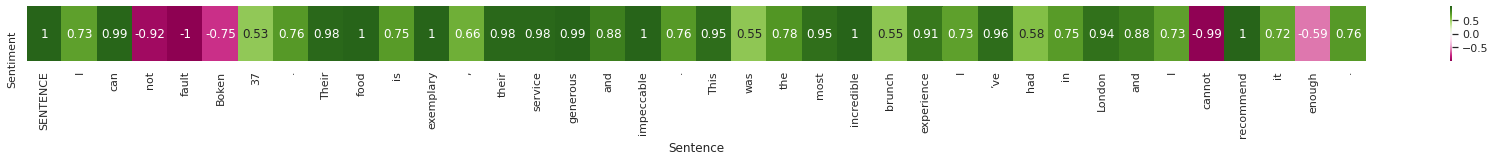

In [ ]:
tokens = [token.text for token in s.tokens]
ss = [flair.data.Sentence(s) for s in tokens]
[flair_sentiment.predict(s) for s in ss]
sentiments = [s.labels[0].score * (-1,1)[str(s.labels[0]).split()[0].startswith("POS")] for s in ss]

visualise_sentiments({
      "Sentence":["SENTENCE"] + tokens,
      "Sentiment":[total_sentiment[0].score *(-1,1)[str(total_sentiment[0]).split()[0].startswith("POS")]] + sentiments,
})

### Rating vs Sentiment score 

#### Vader

In [ ]:
# bokan_full_reviews['vader_score'] = bokan_full_reviews.comment.map(lambda x: sid.polarity_scores(x)['compound'])

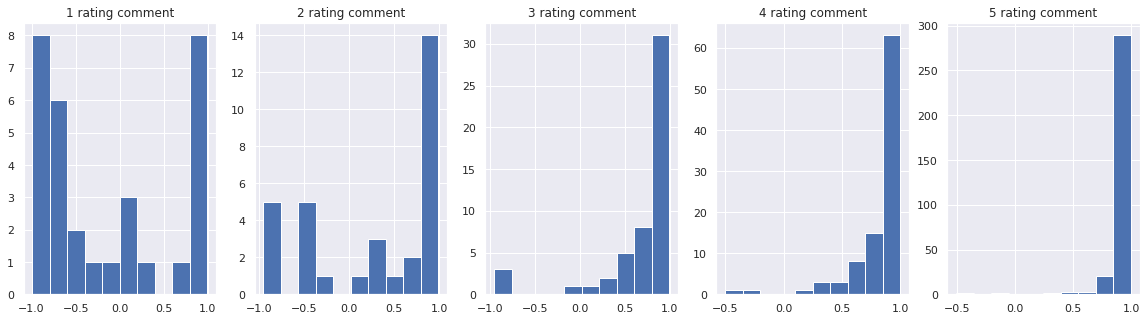

In [ ]:
# f = plt.figure(figsize=(20, 5))
# for i in range(5):
#     rating_doc = bokan_full_reviews[bokan_full_reviews['rating']==i+1]
#     plt.subplot(1, 5, i+1)
#     plt.title(f'{i+1} rating comment')
#     rating_doc.vader_score.hist()
# plt.show()

In [ ]:
!git clone https://github.com/hehlinge42/nlp_consulting_project.git
import os
import pandas as pd

os.chdir("nlp_consulting_project")
bokan_full_reviews = pd.read_json(os.path.join('scraper', 'scraper_rooftops', 'scraped_data', 'reviews', 'reviews_id_2.json'), lines=True)
bokan_full_reviews.set_index(['review_id'], inplace=True)
bokan_full_reviews.head()

Cloning into 'nlp_consulting_project'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 11283 (delta 29), reused 60 (delta 22), pack-reused 11203
Receiving objects: 100% (11283/11283), 1.25 GiB | 16.80 MiB/s, done.
Resolving deltas: 100% (3954/3954), done.
Checking out files: 100% (3366/3366), done.


,restaurant_id,username,date_of_visit,rating,title,comment,date_of_review
review_id,,,,,,,
1,-2,MHB4634,September 2020,4,"Absolutely proper VIP style, but no pints...",I was gobsmacked when I got off the lift. We w...,25 September 2020
2,-2,Nic S,July 2020,3,Wanted to love it but didn't,I think if I had gone to this bar in normal ti...,27 July 2020
3,-2,reeve96,August 2020,5,Nice View,Although it took a while to be served after be...,28 August 2020
4,-2,LornaH72,September 2020,5,Views are amazing,Again the views here are spectacular. Friendly...,13 September 2020
5,-2,Michellehelenar,September 2020,5,Great view for a warm night! Lovely fairy lights,"Really great layout for a warm night, with bla...",18 September 2020


In [ ]:
list_of_words = ['menu', 'food', 'drink', 'drinks', 'cocktail', 'cocktails', 'wine', 'beer', 'service', 'staff', 'place', 'atmosphere', 'ambiance', 'experience', 'music', 'look', 'terrace', 'rooftop', 'price', 'prices']

def sentiment(list_of_words, df):
    matrix = np.zeros(shape=(len(list_of_words), 2))
    for review in df.comment.tolist():
      s = flair.data.Sentence(review)
      flair_sentiment.predict(s)
      total_sentiment = s.labels
      sent = str(total_sentiment[0]).split(' (')[0]
      for i in range(len(list_of_words)):
          if list_of_words[i] in review:
            if sent == 'POSITIVE':
              matrix[i, 0] += 1
            elif sent == 'NEGATIVE':
              matrix[i, 1] += 1
            else:
              print(f"WARNING: {sent}")
    return matrix

In [ ]:
res = sentiment(list_of_words, bokan_full_reviews)
res

array([[ 9.,  6.],
       [45., 14.],
       [51., 26.],
       [39., 17.],
       [44., 14.],
       [37.,  9.],
       [ 4.,  0.],
       [ 2.,  3.],
       [41., 19.],
       [46., 19.],
       [44., 13.],
       [23.,  4.],
       [ 1.,  1.],
       [12.,  7.],
       [14.,  4.],
       [10., 11.],
       [ 8.,  2.],
       [12.,  7.],
       [16., 12.],
       [ 6.,  4.]])

In [ ]:
mat = pd.DataFrame(res, columns=['Positive', 'Negative'])
mat['word'] = list_of_words
mat.set_index(mat.word, inplace=True)
mat.drop(['word'], inplace=True, axis=1)
mat.head()

,Positive,Negative
word,,
menu,9.0,6.0
food,45.0,14.0
drink,51.0,26.0
drinks,39.0,17.0
cocktail,44.0,14.0


In [ ]:
mat['Sum'] = mat.Positive + mat.Negative
mat.Positive = mat.Positive/mat.Sum
mat.Negative = mat.Negative/mat.Sum
mat.drop(['Sum'], inplace=True, axis=1)
mat

,Positive,Negative
word,,
menu,0.600000,0.400000
food,0.762712,0.237288
drink,0.662338,0.337662
drinks,0.696429,0.303571
cocktail,0.758621,0.241379
cocktails,0.804348,0.195652
wine,1.000000,0.000000
beer,0.400000,0.600000
service,0.683333,0.316667


In [ ]:
!pwd
mat.to_csv('./sentiment_savagegardens.csv')

/content/drive/.shortcut-targets-by-id/1ybXeykwPZpH6cQotk9oa_AVlmpjjt82k/Capgemini/nlp_consulting_project
